In [1]:
from __future__ import division, print_function
import numpy as np
from scipy import interpolate
import pyfits
import plotc
import read_params
import matplotlib.pyplot as plt
%matplotlib inline

nx: 512 Lx: 800.0
True psi file: true_psi.fits


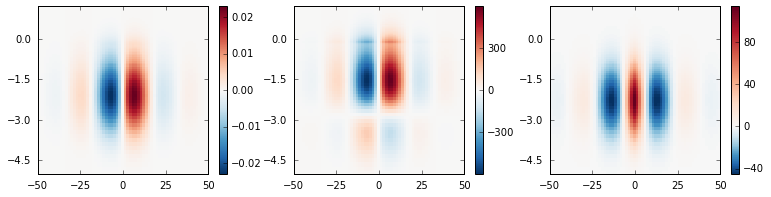

In [2]:
Lx = read_params.get_xlength()
nx = read_params.get_nx()
print("nx:",nx,"Lx:",Lx)
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
Rsun=695.8
z = np.loadtxt(read_params.get_solarmodel(),usecols=[0]); z=(z-1)*Rsun
print("True psi file:",read_params.get_true_psi_filename())
psi_true = np.squeeze(pyfits.getdata(read_params.get_true_psi_filename()))
vx_true = np.squeeze(pyfits.getdata(read_params.get_true_vx_filename()))
vz_true = np.squeeze(pyfits.getdata(read_params.get_true_vz_filename()))
print
gl = plotc.gridlist(1,3)
plotc.colorplot(psi_true,x=x,y=z,yr=[-5,None],xr=[-50,50],sp=next(gl));
plotc.colorplot(vx_true,x=x,y=z,yr=[-5,None],xr=[-50,50],sp=next(gl));
plotc.colorplot(vz_true,x=x,y=z,yr=[-5,None],xr=[-50,50],sp=next(gl));
plt.gcf().set_size_inches(13,3);

## Spline

In [3]:
x_cutoff = 50; z_cutoff = -6
zspline_ind = z>z_cutoff
xspline_ind = abs(x)<x_cutoff
xspline = np.array([x[xspline_ind] for _ in z[zspline_ind]])
zspline = np.array([[i]*len(x[xspline_ind]) for i in z[zspline_ind]])
zx_spline_ind_2D = np.outer(zspline_ind,xspline_ind) 

psi_spline = psi_true[zspline_ind][:,xspline_ind]

Spline fit

In [4]:
tx,tz,c,kx,kz=interpolate.bisplrep(xspline.flatten(),zspline.flatten(),psi_spline.flatten(),kx=2,ky=2,s=1e-5)
print(tx.shape,tz.shape,c.shape)

(20,) (19,) (272,)


In [5]:
psi_spl_fit= interpolate.bisplev(x[xspline_ind],z[zspline_ind],(tx,tz,c,kx,kz))

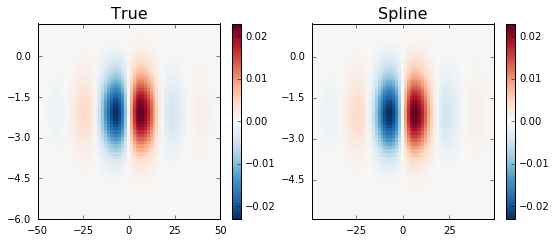

In [6]:
gl=plotc.gridlist(1,2)

plotc.colorplot(psi_true,x=x,y=z,yr=[z_cutoff,None],xr=[-x_cutoff,x_cutoff],sp=next(gl));
plt.title("True",fontsize=16)
plotc.colorplot(psi_spl_fit,x=x[xspline_ind],y=z[zspline_ind],sp=next(gl));
plt.title("Spline",fontsize=16)
plt.gcf().set_size_inches(9,3.5);

### Spline coefficients 

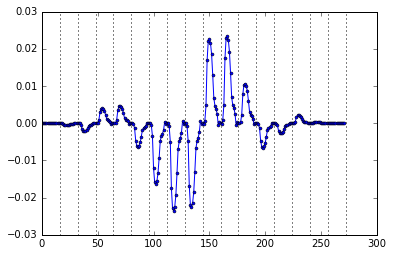

In [7]:
plt.plot(c,'o-',markersize=3)
for i in [(len(tz)-kz-1)*i for i in xrange(1,len(tx)-kx)]: plt.axvline(i,ls="dotted",color="black")

### Surface as it is

At z -1.31598602647 x 6.25 max difference 2.12558602466e-14 %


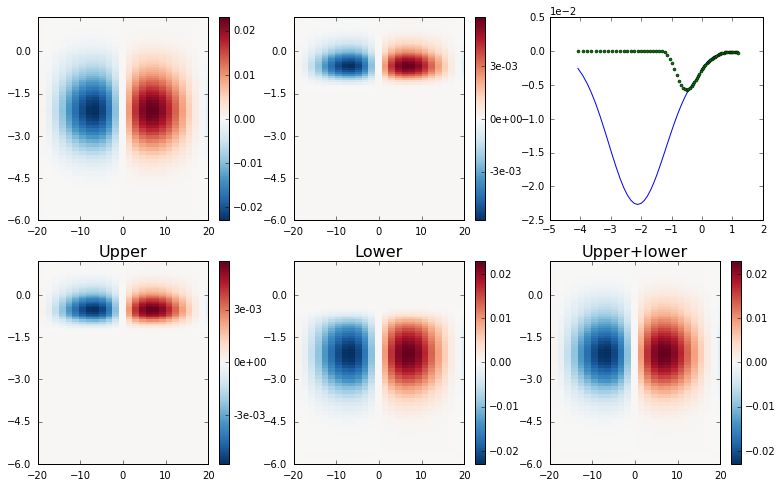

In [8]:
coeff_surf_cutoff_ind = 10

cprime = c.copy().reshape(len(tx)-kx-1,len(tz)-kz-1)
cprime[:,:coeff_surf_cutoff_ind] = 0
cprime = cprime.flatten()
psi_spl_fit_mod = interpolate.bisplev(x[xspline_ind],z[zspline_ind],(tx,tz,cprime,kx,kz))


zspline_ind_int = np.where(zspline_ind)[0]
xspline_ind_int = np.where(xspline_ind)[0]

zspline_ind_ravel = np.ravel([[zi]*len(xspline_ind_int) for zi in zspline_ind_int])
xspline_ind_ravel = np.ravel([xspline_ind_int for _ in zspline_ind_int])

spline_1D_ind = np.ravel_multi_index([zspline_ind_ravel,xspline_ind_ravel],psi_true.shape)
psi_spl_fit_fullsize = np.zeros_like(psi_true)
np.put(psi_spl_fit_fullsize,spline_1D_ind,psi_spl_fit_mod.T.flatten())

gl = plotc.gridlist(2,3)

plotc.colorplot(psi_true,x=x,y=z,yr=[z_cutoff,None],xr=[-20,20],sp=next(gl),centerzero=True);
plotc.colorplot(psi_spl_fit_fullsize,x=x,y=z,xr=[-20,20],yr=[z_cutoff,None],sp=next(gl),centerzero=True);

plt.subplot(next(gl))
x_plot = -8
z_low_cutoff = abs(z+4).argmin()
plt.plot(z[z_low_cutoff:],psi_true[z_low_cutoff:,abs(x-x_plot).argmin()],'b-');
plt.plot(z[z_low_cutoff:],psi_spl_fit_fullsize[z_low_cutoff:,abs(x-x_plot).argmin()],'go',markersize=3);
plt.gca().yaxis.get_major_formatter().set_powerlimits((0, 0))

plotc.colorplot(psi_spl_fit_fullsize,x=x,y=z,xr=[-20,20],yr=[z_cutoff,None],sp=next(gl),centerzero=True);
plt.title("Upper",fontsize=16)

cprime = c.copy().reshape(len(tx)-kx-1,len(tz)-kz-1)
cprime[:,coeff_surf_cutoff_ind:] = 0
cprime = cprime.flatten()
psi_spl_fit_mod2 = interpolate.bisplev(x[xspline_ind],z[zspline_ind],(tx,tz,cprime,kx,kz))
psi_spl_fit_fullsize2 = np.zeros_like(psi_true)
np.put(psi_spl_fit_fullsize2,spline_1D_ind,psi_spl_fit_mod2.T.flatten())
plotc.colorplot(psi_spl_fit_fullsize2,x=x,y=z,xr=[-20,20],yr=[z_cutoff,None],sp=next(gl),centerzero=True);
plt.title("Lower",fontsize=16)

psi_spl_fit_fullsize3 = psi_spl_fit_fullsize+psi_spl_fit_fullsize2
plotc.colorplot(psi_spl_fit_fullsize3,x=x,y=z,xr=[-20,20],yr=[z_cutoff,None],sp=next(gl),centerzero=True);
plt.title("Upper+lower",fontsize=16)


cprime = c.copy().reshape(len(tx)-kx-1,len(tz)-kz-1)
cprime = cprime.flatten()
psi_spl_fit_mod2 = interpolate.bisplev(x[xspline_ind],z[zspline_ind],(tx,tz,cprime,kx,kz))
psi_spl_fit_fullsize2 = np.zeros_like(psi_true)
np.put(psi_spl_fit_fullsize2,spline_1D_ind,psi_spl_fit_mod2.T.flatten())

diff_true_spl = abs(psi_spl_fit_fullsize2-psi_spl_fit_fullsize3)
max_diff_ind = np.unravel_index(diff_true_spl.argmax(),psi_true.shape)
print("At z",z[max_diff_ind[0]],"x",x[max_diff_ind[1]],
      "max difference",diff_true_spl[max_diff_ind]/abs(psi_spl_fit_fullsize2[max_diff_ind])*100,"%")

plt.gcf().set_size_inches(13,8)

## Save coeffs and model to file

In [9]:
print(psi_spl_fit_fullsize.shape)

(300, 512)


In [10]:
import read_params
import warnings
datadir = read_params.get_directory()
model_back = psi_true.max()/1.04
spl_c_shape_xz_2D = (len(tx)-kx-1,len(tz)-kz-1)
c_ref_above_surface = c.copy().reshape(spl_c_shape_xz_2D)
c_ref_below_surface = c.copy().reshape(spl_c_shape_xz_2D)
c_ref_below_surface[:,coeff_surf_cutoff_ind:] = 0
c_ref_above_surface[:,:coeff_surf_cutoff_ind] = 0
c_ref_below_surface = c_ref_below_surface.flatten()
c_ref_above_surface = c_ref_above_surface.flatten()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pyfits.writeto(os.path.join(datadir,"model_psi_ls00.fits"),
                   psi_spl_fit_fullsize[:,np.newaxis,:]+model_back,clobber=True)
    pyfits.writeto(os.path.join(datadir,"model_psi_ls00_start.fits"),
                   psi_spl_fit_fullsize[:,np.newaxis,:]+model_back,clobber=True)
    np.savez(os.path.join(datadir,"model_psi_ls00_coeffs.npz"),back=model_back,c_lower=np.zeros_like(c))
    np.savez(os.path.join(datadir,"model_psi_ls00_coeffs_start.npz"),back=model_back,c_lower=np.zeros_like(c))
    np.savez(os.path.join(datadir,"true_psi_coeffs.npz"),tx=tx,tz=tz,kx=kx,kz=kz,
        c_upper=c_ref_above_surface,c_lower=c_ref_below_surface,coeff_surf_cutoff_ind=coeff_surf_cutoff_ind,
            x_cutoff = x_cutoff, z_cutoff = z_cutoff)